#### Purpose of this kernel - continuance from kernel 6.6

* word is it was originally written is tested on embeddings. (not only "lower()-Version" of the word) 
* Preprocessing function was adapted accordingly

#### Import libraries

In [63]:
# General
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook 
tqdm_notebook().pandas()
import os
import gc
import sys

# Preprocessing
import seaborn as sns
import re
from re import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet as wn
lemmatizer = nltk.WordNetLemmatizer()


# Modeling
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Training
from sklearn.model_selection import StratifiedKFold
  # splits train-set into into train and validation folds
    
# Evaluation
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

#### Hyperparameters

In [64]:
# Fast Run Testing
#total_train_samples = 10000 # max is 1306122
#total_test_samples = 2000 # max is 375806
total_train_samples = 1306122 # max is 1306122
total_test_samples = 375806 # max is 375806

# Preprocessing
maxlen = 130 # 130 covers about 75% of all bad questions completely

# Modeling
embedding_dim = 300 # set to 300 to be able to compare with pre-trained embeddings

# Training
kfolds = 3
model_epochs = 10

### Load Data

In [65]:
df = pd.read_csv("../input/train.csv")
str_ = 'Train data loaded'
os.system('echo '+str_)

0

In [66]:
df = df[:total_train_samples] # for Testing purposes
num_samples,n = df.shape
print("Shape for this run: ", num_samples, n)

X = df.loc[:, 'question_text'].values
y = df.loc[:, 'target'].values

# Since Neural Networks are only able to perform transformations on tensors 
y = np.asarray(y) # Transformation target labels to numpy array 

print('Shape data tensor:', X.shape) 
print('Shape target tensor:', y.shape) # 1D Tensor

pd.set_option('display.max_colwidth', 1500) # inrease display column size
df.head(3)

Shape for this run:  1306122 3
Shape data tensor: (1306122,)
Shape target tensor: (1306122,)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0


### Data Preparation (1)  - tokenization

In [67]:
def my_tokenizer(texts):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(texts) 
        sequences = tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(sequences, maxlen=maxlen)  
        word_index = tokenizer.word_index  
        
        return padded_seq, word_index

### Data Preparation (2)  - Embeddings

In [68]:
# Embeddings path
_glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
_paragram =  '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
_wiki_news = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
_google_news = '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'

embeddings = [{'name': 'glove', 'embeddings_path': _glove},
              {'name': 'paragram', 'embeddings_path': _paragram},
              {'name': 'fasttext', 'embeddings_path': _wiki_news},
              {'name': 'googlenews', 'embeddings_path': _google_news}
             ]

#### Definition of functions to load and analyse embeddings

In [69]:
# Functions for lemmatization from http://textmining.wp.hs-hannover.de/Preprocessing.html

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wn.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wn.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wn.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wn.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)

In [70]:
# Function to create embedding matrix
embedding_matrices = {}
words_in_embedding = {}
def create_model_embedding_matrix(embeddings_name,word_index,embeddings_dict):

    embedding_dim = 300 # (vector size 300!)
    embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
    unknown_words_list = []
    num_known_words = 0  
    
    try: 
        only_words = re.findall(r'\b[a-zA-Z]{3,9}\b',' '.join(embeddings_dict.keys()))
    except:
        only_words = re.findall(r'\b[a-zA-Z]{3,9}\b',' '.join(embeddings_dict.wv.vocab))
        
    word_in_embedding_string = ' '.join(only_words) # for Regex: Only words
        
    ps = PorterStemmer()
    ps_counter = 0
    lc = LancasterStemmer()
    lc_counter = 0
    sb = SnowballStemmer("english")
    sb_counter = 0
    lemma_counter = 0
    re_counter = 0
    j = 0

    # Filling up matrix
    for word, i in tqdm(word_index.items()): 
        
        if embeddings_name in ['glove', 'paragram', 'fasttext']:
            
            embedding_vector = embeddings_dict.get(word) # get vector for word from embedding 
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            word_c = word.lower()
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            word_c = word.capitalize()
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            word_c = word.upper()
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
   
            word_c = ps.stem(word)
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                ps_counter +=1
                continue # if embedding found - process next word
                
            word_c = lc.stem(word)
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                lc_counter +=1
                continue # if embedding found - process next word
                
            word_c = sb.stem(word)
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                sb_counter +=1
                continue # if embedding found - process next word
                             
            word_c = lemmatize(lemmatizer,pos_tag([word])[0][0],wntag(pos_tag([word])[0][1]))
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                lemma_counter +=1
                continue # if embedding found - process next word
            
            if re.match('^[a-zA-Z]{3,9}$',word):  # if word consists only out of letters
                reObj = compile(word, re.I) # ignore case
                m = reObj.search(word_in_embedding_string)
                if m:
                    word_c = m.group(0)
                    if j < 5:
                        print("{:15} --> {}".format(word, word_c))
                        os.system('echo '+ '{:15} --> {}'.format(word, word_c))
                        j +=1
                    embedding_vector = embeddings_dict.get(word_c)
                    if embedding_vector is not None:
                        embedding_matrix[i] = embedding_vector
                        num_known_words +=1
                        re_counter +=1
                        continue # if embedding found - process next word               
                            
            else:
                unknown_words_list.append(word)
                
        if embeddings_name == 'googlenews':
            try:
                embedding_vector = embeddings_dict[word]  
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word

                word_c = word.lower()
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word
                
                word_c = word.capitalize()
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1 
                    continue # if embedding found - process next word
                
                word_c = word.upper()
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word
                                   
                word_c = ps.stem(word)
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    ps_counter +=1
                    continue # if embedding found - process next word
                    
                word_c = lc.stem(word)
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    lc_counter +=1
                    continue # if embedding found - process next word
                    
                word_c = sb.stem(word)
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    sb_counter +=1
                    continue # if embedding found - process next word
                    
                word_c = lemmatize(lemmatizer,pos_tag([word])[0][0],wntag(pos_tag([word])[0][1]))
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    lemma_counter +=1
                    continue # if embedding found - process next word
                    
                if re.match('^[a-zA-Z]{3,9}$',word):     
                    reObj = compile(word, re.I) # ignore case
                    m = reObj.search(word_in_embedding_string)
                    if m:
                        word_c = m.group(0)
                        if j < 5:
                            print("{:15} --> {}".format(word, word_c))
                            os.system('echo '+ "{:15} --> {}".format(word, word_c))
                            j +=1
                        embedding_vector = embeddings_dict[word_c]
                        if embedding_vector is not None:
                            embedding_matrix[i] = embedding_vector
                            num_known_words +=1
                            re_counter +=1
                            continue # if embedding found - process next word               
                   
            except:
                unknown_words_list.append(word)
                
    try: 
        words_in_embedding[embeddings_name] = list(embeddings_dict.keys())
    except:
        try:
            words_in_embedding[embeddings_name] = list(embeddings_dict.wv.vocab)
        except:
            print("Error during generation of key list {}".format(embeddings_name))
            print(sys.exc_info()[0])
    
    print('  Embeddings_matrix created')
    print('  Shape embedding_matrix: {}'.format(embedding_matrix.shape))
    print('  Found Embeddings for {:.2f}% of all words'
          .format((num_known_words / len(word_index))*100))
    print("  num_known_words :", num_known_words)
    print("  num words in word_index: ", len(word_index))
    print('  Unknown Words: {:.2f}%'.
          format(((len(unknown_words_list)) / len(word_index))*100))
    print("  Words found by PorterStemmer: {}".format(ps_counter))
    print("  Words found by LancasterStemmer: {}".format(lc_counter))
    print("  Words found by SnowballStemmer: {}".format(sb_counter))
    print("  Words found by Lemmatisation: {}".format(lemma_counter))
    print("  Words found by Regex: {}".format(re_counter))
          
    # Top 50 unknown words
    print("  Top 50 unknown words:\n {}\n".format(unknown_words_list[:50]))
    
    del num_known_words, unknown_words_list,ps,lc,sb, ps_counter, lc_counter, sb_counter
    del embedding_matrix, lemma_counter, re_counter, j, word_in_embedding_string, only_words
    gc.collect() 

In [71]:
# Function to load + analyze Embeddings
def load_and_analyse_Embeddings(embeddings_name, embeddings_path):
    
    if embeddings_name in ['glove', 'paragram', 'fasttext']:  
        embeddings_dict = {} # create empty embedding dictionary
        embedding_file = open(embeddings_path, encoding ="utf8", errors = 'ignore') # load embedding from path

        # Fill embedding dict with word: vector(coefs) pairs
        for line in embedding_file:
            line_values = line.split(' ') # read in values of respective line (= vector)
            word = line_values[0] #  # first value in line represents the word
            coefs = np.asarray(line_values[1:], dtype='float32') # all values represent vector
            embeddings_dict[word] = coefs # add key(word), value(vector) pairs to dict

        embedding_file.close() 
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        print('  {} word vectors within {} dict'.format(len(embeddings_dict),embeddings_name))
        
        # Use pre-trained embedding to create final embeddings matrix
        create_model_embedding_matrix(embeddings_name,word_index,embeddings_dict)
        del embeddings_dict, line_values,word,coefs
                
    if embeddings_name == 'googlenews':
        embeddings_file = KeyedVectors.load_word2vec_format(embeddings_path, binary=True)
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        
        # Use pre-trained embedding to create final embeddings matrix
        create_model_embedding_matrix(embeddings_name,word_index,embeddings_file)
        del embeddings_file
        
    # MEMORY MANAGEMENT!
    del embeddings_name, embeddings_path
    gc.collect()
    
   # return embeddings_dict

### Data Preparation (3)  - Data Cleaning

#### Definition mapping and functions

In [72]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am","i'm": "i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                       "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not","what`s": "what is", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                       "you're": "you are", "you've": "you have"}

# dict from https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 
correct_spell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite',
                    'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                    'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization',
                    'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                    'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                    'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
                    'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many',
                    'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best',
                    'howdoes': 'how does', 'mastrubation': 'masturbation',
                    'mastrubate': 'masturbate', "mastrubating": 'masturbating',
                    "mcdonald's":'mcdonalds',
                    'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist',
                    'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 
                    'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                    'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                    'demonitization': 'demonetization', 'demonetisation': 'demonetization',
                    'pokémon': 'pokemon', 'quoras': 'quora', 'quorans': 'quora'}

# Kernel "fork-embeddings-keras-v04"
specials_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", 
                 "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', 
                 '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 
                 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '\u200b': ' ',
                 '…': ' ... ', '\ufeff': '', 'करना': '', 'है': '', 'ε−': ''}

punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [73]:
def clean_numbers(x):
    # replaces one digit by #, two following digits by ## etc.
    x = re.sub('[0-9]{5,}', '#####', x) 
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def preprocessing(x):
    x = str(x)
    x = re.sub('[’‘´`]', "'", x) 
    
    for word in x.split():
        if word.lower() in contraction_mapping.keys():
            x = x.replace(word, contraction_mapping[word.lower()])
        if word in correct_spell_dict.keys():
            x = x.replace(word, correct_spell_dict[word])
        if word in specials_mapping.keys():
            x = re.sub(word, specials_mapping.get(word),x) 
            
    x = re.sub('\'s\s+', ' \'s ', x)
    x = ' '.join(word_tokenize(x))    
    return x

#### Apply preprocessing functions

In [74]:
os.system('echo Applying preprocessing functions..')
df["question_text"] = df["question_text"].fillna("_nan_").progress_apply(lambda x: preprocessing(x))
os.system('echo prepocessing done')
df["question_text"] = df["question_text"].progress_apply(lambda x: clean_numbers(x))
os.system('echo clean_numbers done')

X = df.loc[:, 'question_text'].values
y = np.asarray(df.loc[:, 'target'].values)

padded_seq, word_index = my_tokenizer(X) # Tokenization
os.system('echo Tokenization 2 completed')

0

#### Word length distribution (for Regex)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


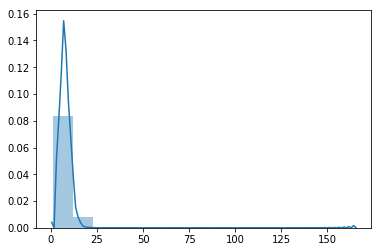

In [75]:
l = []
for key, _ in tqdm(word_index.items()):
    l.append(len(key))  
sns.distplot(l, bins = 15)

#### Iteration loop to compare different embeddings (3)

In [76]:
for embedding in embeddings:
    emb_name = embedding['name']
    emb_path = embedding['embeddings_path']
    print("Running procedure on {}:".format(emb_name))
    
    load_and_analyse_Embeddings(emb_name, emb_path) # loading embedding

Running procedure on glove:
   glove loaded
  2196016 word vectors within glove dict


  2%|▏         | 3665/192332 [00:02<01:52, 1680.13it/s]

redmi           --> Redmi


  4%|▍         | 7788/192332 [00:02<01:18, 2341.57it/s]

oneplus         --> oneplus


  4%|▍         | 8574/192332 [00:03<01:11, 2588.02it/s]

upwork          --> upwork


  8%|▊         | 15895/192332 [00:07<03:45, 782.74it/s] 

ftre            --> ftre


  8%|▊         | 16192/192332 [00:07<03:02, 963.05it/s]

hotstar         --> HotStar


100%|██████████| 192332/192332 [51:55<00:00, 61.74it/s]  


  Embeddings_matrix created
  Shape embedding_matrix: (192333, 300)
  Found Embeddings for 77.99% of all words
  num_known_words : 149998
  num words in word_index:  192332
  Unknown Words: 10.50%
  Words found by PorterStemmer: 3434
  Words found by LancasterStemmer: 4642
  Words found by SnowballStemmer: 3846
  Words found by Lemmatisation: 79
  Words found by Regex: 562
  Top 50 unknown words:
 ['cryptocurrencies', '₹', "'i", 'adityanath', "'a", "qur'an", "5'", 'tensorflow', 'kavalireddi', '°c', 'etc…', "5'4", "5'9", 'hackerrank', "5'7", "5'3", "5'2", "5'5", 'demonetisation', "5'6", "5'8", 'x²', 'nanodegree', 'what\u200b', 'microservices', '√3', 'truecaller', '√2', 'chromecast', 'dies™', "6'1", 'bitconnect', "'r", "6'2", 'xxxtentacion', "'x", 'kmno4', 'codeforces', 'arrowverse', 'internshala', 'chapterwise', 'genderfluid', 'ravindrababu', 'kubernetes', 'undergraduation', "6'4", 'hackerearth', '√x', 'wikitribune', 'how\u200b']

Running procedure on paragram:
   paragram loaded
  1703

  2%|▏         | 3665/192332 [00:00<00:19, 9832.24it/s] 

redmi           --> redmi


  4%|▍         | 8371/192332 [00:00<00:21, 8449.06it/s] 

oneplus         --> oneplus
upwork          --> upwork


  8%|▊         | 16019/192332 [00:04<02:04, 1416.82it/s]

ftre            --> ftre
hotstar         --> hotstar


100%|██████████| 192332/192332 [36:10<00:00, 88.59it/s]  


  Embeddings_matrix created
  Shape embedding_matrix: (192333, 300)
  Found Embeddings for 79.14% of all words
  num_known_words : 152208
  num words in word_index:  192332
  Unknown Words: 10.05%
  Words found by PorterStemmer: 4216
  Words found by LancasterStemmer: 5275
  Words found by SnowballStemmer: 3988
  Words found by Lemmatisation: 77
  Words found by Regex: 0
  Top 50 unknown words:
 ['cryptocurrencies', '₹', "'i", 'adityanath', "'a", "qur'an", "5'", 'tensorflow', 'kavalireddi', '°c', 'etc…', "5'4", "5'9", 'hackerrank', "5'7", "5'3", "5'2", "5'5", 'demonetisation', "5'6", "5'8", 'x²', 'nanodegree', 'what\u200b', 'microservices', '√3', '√2', 'chromecast', 'dies™', "6'1", 'bitconnect', "'r", "6'2", 'xxxtentacion', "'x", 'codeforces', 'arrowverse', 'internshala', 'chapterwise', 'genderfluid', 'ravindrababu', 'kubernetes', 'undergraduation', "6'4", 'hackerearth', '√x', 'wikitribune', 'how\u200b', "''the", "i'am"]

Running procedure on fasttext:
   fasttext loaded
  999995 word 

  4%|▍         | 7353/192332 [00:00<00:15, 11828.27it/s]

oneplus         --> OnePlus


  4%|▍         | 8256/192332 [00:01<00:36, 5015.60it/s] 

uceed           --> uceed


  5%|▍         | 8953/192332 [00:01<00:37, 4830.93it/s]

chsl            --> chsl


  5%|▍         | 9574/192332 [00:01<01:14, 2452.93it/s]

naoh            --> NaOH
devops          --> DevOps


100%|██████████| 192332/192332 [38:18<00:00, 83.67it/s]  


  Embeddings_matrix created
  Shape embedding_matrix: (192333, 300)
  Found Embeddings for 72.36% of all words
  num_known_words : 139168
  num words in word_index:  192332
  Unknown Words: 11.93%
  Words found by PorterStemmer: 3447
  Words found by LancasterStemmer: 4947
  Words found by SnowballStemmer: 3114
  Words found by Lemmatisation: 142
  Words found by Regex: 910
  Top 50 unknown words:
 ["''", "n't", "qur'an", 'aliexpress', 'tensorflow', 'kavalireddi', '°c', 'etc…', 'woocommerce', "d'angelo", "5'4", "5'9", 'hackerrank', "5'7", "5'3", "5'2", "5'5", "5'6", "5'8", 'x²', 'nanodegree', 'what\u200b', '√3', '√2', "o'reilly", 'dies™', "6'1", 'bitconnect', 'multibagger', "6'2", 'xxxtentacion', 'kmno4', 'codeforces', 'electroneum', 'internshala', 'chapterwise', 'ravindrababu', "baha'i", 'undergraduation', "don'ts", '1z0', "6'4", 'hackerearth', 'netbanking', 'sin2x', '√x', 'how\u200b', 'bookmyshow', "o'brien", "i'am"]

Running procedure on googlenews:
   googlenews loaded


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
100%|██████████| 192332/192332 [00:00<00:00, 232523.90it/s]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:195: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


  Embeddings_matrix created
  Shape embedding_matrix: (192333, 300)
  Found Embeddings for 39.86% of all words
  num_known_words : 76666
  num words in word_index:  192332
  Unknown Words: 60.14%
  Words found by PorterStemmer: 0
  Words found by LancasterStemmer: 0
  Words found by SnowballStemmer: 0
  Words found by Lemmatisation: 0
  Words found by Regex: 0
  Top 50 unknown words:
 ['a', 'to', 'of', 'and', "'s", "''", 'quora', "'", '”', '“', 'instagram', 'upsc', 'bitcoin', 'mbbs', 'whatsapp', 'ece', 'aiims', 'iim', 'sbi', 'cgl', 'cryptocurrency', 'quorans', 'btech', 'snapchat', 'obc', 'jio', 'manipal', 'bba', 'icse', 'tcs', 'srm', 'wwii', 'blockchain', 'narendra', 'elon', 'iiit', 'bitsat', 'cgpa', 'ielts', 'brexit', 'mtech', 'iits', 'cryptocurrencies', 'ncert', 'behaviour', 'programme', 'clat', 'isro', 'upvotes', 'bca']



#### Search certain words in the embeddings

In [77]:
my_re = compile('angularjs', re.I) # ignore case
for embedding in words_in_embedding:
    if any(my_re.match(line) for line in words_in_embedding[embedding]):
        print("{}: Matched!".format(embedding))#

    for line in words_in_embedding[embedding]:
        if any(my_re.match(word) for word in line.split()):
            print(line)

glove: Matched!
AngularJS
angularjs
paragram: Matched!
angularjs
fasttext: Matched!
AngularJS


#### Are there vectors for Interpunctuation in the embeddings?

In [78]:
re = compile('[,\.!"()"]') # search some interpunctuation marks
for embedding in words_in_embedding:
    if any(re.match(line) for line in words_in_embedding[embedding]):
        print("{}: Matched!".format(embedding))#
        
# no punctuation in googlenews!

glove: Matched!
paragram: Matched!
fasttext: Matched!
googlenews: Matched!


#### Are there any uppercase words in the embeddings?

In [79]:
re = compile('[A-Z]{1,}\w+') # match leading upper case letter
for embedding in words_in_embedding:
        print("{}: Matched!".format(embedding))
        print(re.findall(' '.join(words_in_embedding[embedding]))[:10])
        
# yes there are capitalized letters!
# paragram embedding seems not to have capital letters. Only one strange "UUUNKKK"

glove: Matched!
['The', 'It', 'This', 'In', 'You', 'We', 'If', 'And', 'New', 'For']
paragram: Matched!
['UUUNKKK']
fasttext: Matched!
['The', 'Wikipedia', 'In', 'UTC', 'If', 'But', 'This', 'It', 'And', 'He']
googlenews: Matched!
['The', 'It', 'He', 'We', 'In', 'But', 'This', 'They', 'By', 'If']


#### Are there any uppercase only words in the embeddings?

In [80]:
re = compile('[A-Z]{2,}') # match uppercase only words
            # (at least two following upperacse letters)
for embedding in words_in_embedding:
        print("{}: ".format(embedding))
        print(re.findall(' '.join(words_in_embedding[embedding]))[:10])

glove: 
['PM', 'AM', 'THE', 'US', 'TV', 'UK', 'OF', 'AND', 'USA', 'TO']
paragram: 
['UUUNKKK']
fasttext: 
['UTC', 'US', 'WP', 'UK', 'II', 'TV', 'USA', 'POV', 'EU', 'IP']
googlenews: 
['AP', 'TV', 'UK', 'CEO', 'UN', 'NFL', 'EU', 'IT', 'WASHINGTON', 'NEW']


#### Having a look at the sentences that contain unknown words

In [81]:
my_re = compile('angularjs', re.I) # ignore case
for line in df["question_text"].values:
    if any(my_re.match(word) for word in line.split()) and (i < 5):
            print(line)
            i += 1   

AttributeError: '_sre.SRE_Pattern' object has no attribute 'I'